Customizing Workflows
===================

This notebook shows how to write workflows for BQSKit, using the Hubbard Model$^1$ as an exemplar. The Hubbard Model is only briefly introduced; full details on the Hubbard Model, the Variational Quantum Eigensolver, the effects of noise, and more, can be found as part of the scikit-quant tutorials.$^2$

Prerequisites: OpenFermion, Qiskit, BQSKit, and SciPy (which will pull in NumPy), as well as optionally scikit-quant, e.g. install with pip:

`$ python -m pip install openfermion qiskit bqskit scipy`

Contents
-----------

This tutorial is setup to be run serially for the first several sections, as lessons learned (and code) are used in subsequent sections. However, afterwards it is possible to skip and jump ahead if a specific focus is of more interest.

* Work through in series:
   * [Introduction to the Hubbard Model](#Introduction)
   * [Effects of circuit structure on synthesis](#Energy-Objective)
   * [Running BQSKit synthesis in VQE](#Variational-Quantum-Eigensolver)
* Work through in series, or pick and choose:
   * [Customizing BQSKit workflows](#Customized-Compilation)
   * [Seeded synthesis](#Seeded-Synthesis)
   * [Implications of noise](#Implications-of-Noise)

Introduction
--------------

We will solve the Hubbard Model using the Variational Quantum Eigensolver (VQE) algorithm. The Hubbard Model (HM) has a range of uses, most notably in solid-state physics to explain phase transitions and other correlated behaviors. There are several variations of the HM, but in essence, the model describes interacting particles on a lattice. Despite its apparent simplicity, it is hard to solve on a classical computer because the known algorithms scale exponentially unless further approximations are made. In this tutorial, we will use the VQE algorithm to estimate the energy ground states of different configurations of an HM.

Basic Fermi-Hubbard Model
---------------------------------

We will restrict ourselves to a Hubbard Model with fermions (such as electrons), i.e. the Fermi-Hubbard Model. A visualization of an example with a 2x2 grid with spinful electrons is shown below. Electrons being fermions means that two electrons can not occupy the same quantum state. Because the electrons have spin, there can thus be at most two electrons per site (one spin-up, one spin-down). The model is characterized by an interaction term 'U', which only contributes if a spin-up and a spin-down electron occupy the same site; and by a "hopping" term 't', representing the kinetic energy in the system. In this basic model, only hops to neighboring sites are considered.

<table style="padding: 0px"><tr></tr><tr>
<td style="width: 65%; padding: 0px">
<div align="left" style="text-align: left; font-size: 120%">
The energy in the model is described by the following Hamiltonian using fermion algebra:
<br>
<p>\begin{equation*}
H = -t \sum_{ij,\sigma=\uparrow\downarrow} {a_{i\sigma}^\dagger a_{j\sigma}} + U \sum_i {a_{i\uparrow}^\dagger a_{i\uparrow} a_{i\downarrow}^\dagger a_{i\downarrow}}
\end{equation*}</p>
where:
<ul>
    <li>$a_{i\sigma}^\dagger$ = creation operator for site 'i' and spin $\sigma$</li>
    <li>$a_{i\sigma}$ = annihilation operator for site 'i' and spin $\sigma$</li>
    <li>U = interaction term</li>
    <li>t = hopping term</li>
</ul>
<p>The first sum quantifies moving electrons from each site 'j' to each neighboring site 'i' (first term, that is: $a_i^\dagger$ "creates" an electron at site 'i' while $a_j$ simultaneously "annihilates" it from site 'j'), and vice versa (second term), considering both up and down spins ($\sigma$) independently; the second sum quantifies the interaction contribution for having two electrons, one up and one down, at the same site 'i'.
</p></div></td>
    <td>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</td>
<td style="width: 35%">
    <img src='./images/basic_fermi_hubbard_model.png'>
</td>
</tr></table>

<p>
Although the pictorial shows the electrons as concrete particles, the model treats them as waves that extend over all sites. A solution to the model provides the probabilities with which any of the electrons can be measured, as a particle, at each one of the sites.

Mapping fermions to qubits
---------------------------------

Fermion algebra is only a subset of what a quantum computer can express, since fermions are interchangeable and many states are thus completely equivalent, whereas qubits are identifiable (each one has a well defined location on a chip or ion trap, for example). Thus, it is useful to perform a mapping from fermion to qubit algebra that preserves the fermionic relations, to ensure that the mapped operators only produce states inside that fermionic subset; meaning that the computation should not, noise aside, produce non-physical states. Doing so reduces the scope for errors.$^3$

There are several possible mappings from fermion to qubit operators that preserve the fermion algebra. Here, we'll consider the Jordan-Wigner$^4$ and Bravyi-Kitaev$^5$ transforms, because these are commonly used and easy to understand and their differences$^6$ show an important point about how the optimizability of circuits.

To get started, first load some relevant modules and helper functions.

In [1]:
%load_ext autoreload

In [2]:
# useful tools
import logging
import numpy as np
import qiskit as qk
import scipy
from timeit import default_timer as timer

# BQSKit tooling
import bqskit
from bqskit.ext import qiskit_to_bqskit

# VQE objective function for Hamiltonians
from hubbard import EnergyObjective, hamiltonian_qiskit, hubbard

In [3]:
def display_circuit(circuit, basis=['u', 'cx']):
    """perform basic, unoptimized decomposition for circuit display"""

    uc =  qk.transpile(circuit, basis_gates=basis)
    
    for gate, count in uc.count_ops().items():
        print("gate %s count: %d" % (gate, count))

    return uc.draw()

The Fermi-Hubbard model is defined by the dimensions of the 2D grid, plus the hopping and interaction terms. In addition, OpenFermion allows some variations on the team by making the electrons spinless and making the grid periodic. Below is a very small model, just 2 sites (2x1), which will result in 2 classical optimization parameters. You can try a larger model, but this small example is chosen for a tutorial session where it can be easily run on a laptop on battery power.

In [4]:
# Setup for a 2x1 grid with a single electron.
hm_lattice = {
    'x_dimension' : 2,
    'y_dimension' : 1,      # 2D x_dim * y_dim grid
    'tunneling'   : 1.0,    # hpping term `t`
    'coulomb'     : 2.0,    # interaction term `U`
    'spinless'    : False,  # double negative, so do have spins
    'periodic'    : False,  # do not allow wrap-around hopping
}

hm_filling = {
    'n_electrons_up'   : 1,
    'n_electrons_down' : 0,
}

Energy Objective
--------------------

The Variational Quantum Eigensolver is an iterative algorithm where a classical optimizer minimizes an energy objective (the expectation value of the Hamiltonian) as calculated on the quantum computer. Typically, an Hamiltonian has many components, which can be evaluated in parallel, on separate quantum chips/computers. The final result is obtained by summing the parts classically using their proper weights.
<table style="padding: 0px"><tr></tr><tr>
<td style="width: 60%; padding: 0px">
<div align="left" style="text-align: left; font-size: 120%">
The trial quantum states proposed by the classical optimizer are constructed using an <i>Ansatz</i> that is parametrized using classical values only.
Here, we wil use <i>Unitary Coupled Cluster</i> Ansatz for single and double excitations (UCCSD). Briefly, this Ansatz explores the search space by moving single electrons and by swapping pairs.
This Ansatz is easier on the classical optimizer than many alternatives, but produces rather deep circuits, which is why the use of a tool like BQSKit becomes a necessity.
</div></td>
<td><img src='./images/vqe_structure.png'></td>
</tr></table>
To complete a circuit, we need to fill it with electrons and then instantiate the circuit for a set of optimization paremeters. Note that the meaning of these parameters depends on the chosen mapping.

In [5]:
# Hubbard Model Hamiltonian using Jordan-Wigner mapping
hm_jw = hamiltonian_qiskit(fermion_transform='jordan-wigner', **hm_lattice)

# create an energy objective, which can be minimized classically, from the mapped hamiltonian
jw_objective = EnergyObjective(hm_jw, **hm_filling)

# instantiate a circuit from a set of classical parameters
jw_circuit_instance = jw_objective.generate_circuit([0.1]*jw_objective.npar())

# visualize the circuit, using basic gates, and collect some statistics
c_jw = qk.transpile(jw_circuit_instance, basis_gates=["u3", "cx"])

for gate, count in c_jw.count_ops().items():
    print("gate %s count: %d" % (gate, count))
    
c_jw.draw()

gate cx count: 124
gate u3 count: 110


global phase: 0
     ┌───────────────┐          ┌───┐┌────────────────┐┌───┐»
q_0: ┤ U3(π/2,-π,-π) ├──────────┤ X ├┤ U3(0,0,-0.025) ├┤ X ├»
     └┬─────────────┬┘     ┌───┐└─┬─┘└────────────────┘└─┬─┘»
q_1: ─┤ U3(π/2,0,π) ├──────┤ X ├──■──────────────────────■──»
      ├─────────────┤ ┌───┐└─┬─┘                            »
q_2: ─┤ U3(π/2,0,π) ├─┤ X ├──■──────────────────────────────»
     ┌┴─────────────┴┐└─┬─┘                                 »
q_3: ┤ U3(π/2,0,π/2) ├──■───────────────────────────────────»
     └───────────────┘                                      »
«     ┌──────────────────────┐                                                 »
«q_0: ┤ U3(0,1.4066,-1.4066) ├─────────────────────────────────────────────────»
«     └────────┬───┬─────────┘┌──────────────────────┐                         »
«q_1: ─────────┤ X ├──────────┤ U3(0,1.4066,-1.4066) ├─────────────────────────»
«              └─┬─┘          └────────┬───┬─────────┘┌──────────────────┐┌───┐»
«q_2: ───────────■─────────────────────┤ X ├──────────┤ U3(π/2,π/2,-π/2) ├┤ X ├»
«                                      └─┬─┘          ├──────────────────┤└─┬─┘»
«q_3: ───────────────────────────────────■────────────┤ U3(π/2,-π/2,π/2) ├──■──»
«                                                     └──────────────────┘     »
«          ┌───┐┌────────────────┐┌───┐┌──────────────────────┐»
«q_0: ─────┤ X ├┤ U3(0,0,-0.025) ├┤ X ├┤ U3(0,1.4066,-1.4066) ├»
«     ┌───┐└─┬─┘└────────────────┘└─┬─┘└────────┬───┬─────────┘»
«q_1: ┤ X ├──■──────────────────────■───────────┤ X ├──────────»
«     └─┬─┘                                     └─┬─┘          »
«q_2: ──■─────────────────────────────────────────■────────────»
«                                                              »
«q_3: ─────────────────────────────────────────────────────────»
«                                                              »
«                                                           ┌───┐»
«q_0: ──────────────────────────────────────────────────────┤ X ├»
«     ┌──────────────────┐                             ┌───┐└─┬─┘»
«q_1: ┤ U3(π/2,π/2,-π/2) ├─────────────────────────────┤ X ├──■──»
«     └──────┬───┬───────┘  ┌──────────────────┐  ┌───┐└─┬─┘     »
«q_2: ───────┤ X ├──────────┤ U3(π/2,-π/2,π/2) ├──┤ X ├──■───────»
«            └─┬─┘        ┌─┴──────────────────┴─┐└─┬─┘          »
«q_3: ─────────■──────────┤ U3(0,1.4066,-1.4066) ├──■────────────»
«                         └──────────────────────┘               »
«     ┌───────────────┐┌───┐┌──────────────────────┐                        »
«q_0: ┤ U3(0,0,0.025) ├┤ X ├┤ U3(0,1.4066,-1.4066) ├────────────────────────»
«     └───────────────┘└─┬─┘└────────┬───┬─────────┘┌──────────────────────┐»
«q_1: ───────────────────■───────────┤ X ├──────────┤ U3(0,1.4066,-1.4066) ├»
«                                    └─┬─┘          └────────┬───┬─────────┘»
«q_2: ─────────────────────────────────■─────────────────────┤ X ├──────────»
«                                                            └─┬─┘          »
«q_3: ─────────────────────────────────────────────────────────■────────────»
«                                                                           »
«                                   ┌───┐┌────────────────┐┌───┐»
«q_0: ──────────────────────────────┤ X ├┤ U3(0,0,-0.025) ├┤ X ├»
«                              ┌───┐└─┬─┘└────────────────┘└─┬─┘»
«q_1: ─────────────────────────┤ X ├──■──────────────────────■──»
«     ┌──────────────────┐┌───┐└─┬─┘                            »
«q_2: ┤ U3(π/2,π/2,-π/2) ├┤ X ├──■──────────────────────────────»
«     ├──────────────────┤└─┬─┘                                 »
«q_3: ┤ U3(π/2,π/2,-π/2) ├──■───────────────────────────────────»
«     └──────────────────┘                                      »
«     ┌──────────────────────┐                                               »
«q_0: ┤ U3(0,1.4066,-1.4066) ├───────────────────────────────────────────────»
«     └────────┬───┬─────────┘┌────────────────┐       

**Exercise:** Instantiate an energy objective like before, but now for the Bravyi-Kitaev mapping. Draw and compare the generated circuits, find the main differences in structure, and try to guess how that might affect the synthesis, in particular based on what you have learned about partitioning.  

In [6]:
# Hubbard Model Hamiltonian using Bravyi-Kitaev mapping
hm_bk = hamiltonian_qiskit(fermion_transform='bravyi-kitaev', **hm_lattice)

# create an energy objective, which can be minimized classically, from the mapped hamiltonian
bk_objective = EnergyObjective(hm_bk, **hm_filling)

# instantiate a circuit from a set of classical parameters
bk_circuit_instance = bk_objective.generate_circuit([0.1]*bk_objective.npar())

# visualize the circuit, using basic gates, and collect some statistics
c_bk = qk.transpile(bk_circuit_instance, basis_gates=["u3", "cx"])

for gate, count in c_bk.count_ops().items():
    print("gate %s count: %d" % (gate, count))
    
c_bk.draw()

gate cx count: 90
gate u3 count: 80


global phase: 4.6124
      ┌───────────────┐      ┌───┐┌──────────────┐┌───┐┌──────────────────────┐»
q_0: ─┤ U3(π/2,-π,-π) ├──────┤ X ├┤ U3(0,0,0.05) ├┤ X ├┤ U3(0,1.4066,-1.4066) ├»
     ┌┴───────────────┴┐┌───┐└─┬─┘└──────────────┘└─┬─┘└────────┬───┬─────────┘»
q_1: ┤ U3(π/2,-π,-π/2) ├┤ X ├──■────────────────────■───────────┤ X ├──────────»
     └─┬─────────────┬─┘└─┬─┘                                   └─┬─┘          »
q_2: ──┤ U3(π/2,0,π) ├────■───────────────────────────────────────■────────────»
       └┬───────────┬┘                                                         »
q_3: ───┤ U3(π,0,π) ├──────────────────────────────────────────────────────────»
        └───────────┘                                                          »
«                              ┌───┐┌────────────────┐┌───┐»
«q_0: ─────────────────────────┤ X ├┤ U3(0,0,-0.025) ├┤ X ├»
«      ┌────────────────┐ ┌───┐└─┬─┘└────────────────┘└─┬─┘»
«q_1: ─┤ U3(π/2,π/2,-π) ├─┤ X ├──■──────────────────────■──»
«     ┌┴────────────────┴┐└─┬─┘                            »
«q_2: ┤ U3(π/2,π/2,-π/2) ├──■──────────────────────────────»
«     └──────────────────┘                                 »
«q_3: ─────────────────────────────────────────────────────»
«                                                          »
«     ┌──────────────────────┐                                  ┌───┐»
«q_0: ┤ U3(0,1.4066,-1.4066) ├──────────────────────────────────┤ X ├»
«     └────────┬───┬─────────┘                             ┌───┐└─┬─┘»
«q_1: ─────────┤ X ├───────────────────────────────────────┤ X ├──■──»
«              └─┬─┘          ┌──────────────────────┐┌───┐└─┬─┘     »
«q_2: ───────────■────────────┤ U3(0,1.4066,-1.4066) ├┤ X ├──■───────»
«                             └──────────────────────┘└─┬─┘          »
«q_3: ──────────────────────────────────────────────────■────────────»
«                                                                    »
«     ┌────────────────┐┌───┐┌──────────────────────┐                 »
«q_0: ┤ U3(0,0,-0.025) ├┤ X ├┤ U3(0,1.4066,-1.4066) ├─────────────────»
«     └────────────────┘└─┬─┘└────────┬───┬─────────┘┌───────────────┐»
«q_1: ────────────────────■───────────┤ X ├──────────┤ U3(π/2,0,π/2) ├»
«                                     └─┬─┘          └─────┬───┬─────┘»
«q_2: ──────────────────────────────────■──────────────────┤ X ├──────»
«                                                          └─┬─┘      »
«q_3: ───────────────────────────────────────────────────────■────────»
«                                                                     »
«                             ┌───┐┌────────────────┐┌───┐»
«q_0: ────────────────────────┤ X ├┤ U3(0,0,-0.025) ├┤ X ├»
«                             └─┬─┘└────────────────┘└─┬─┘»
«q_1: ──────────────────────────┼──────────────────────┼──»
«     ┌──────────────────────┐  │                      │  »
«q_2: ┤ U3(0,1.4066,-1.4066) ├──■──────────────────────■──»
«     └──────────────────────┘                            »
«q_3: ────────────────────────────────────────────────────»
«                                                         »
«     ┌──────────────────────┐     ┌───┐┌────────────────┐┌───┐»
«q_0: ┤ U3(0,1.4066,-1.4066) ├─────┤ X ├┤ U3(0,0,-0.025) ├┤ X ├»
«     └──────────────────────┘     └─┬─┘└────────────────┘└─┬─┘»
«q_1: ───────────────────────────────┼──────────────────────┼──»
«     ┌──────────────────────┐┌───┐  │                      │  »
«q_2: ┤ U3(0,1.4066,-1.4066) ├┤ X ├──■──────────────────────■──»
«     └──────────────────────┘└─┬─┘                            »
«q_3: ──────────────────────────■──────────────────────────────»
«                                                              »
«     ┌──────────────────┐                             ┌───┐┌──────────────┐»
«q_0: ┤ U3(π/2,π/2,-π/2) ├─────────────────────────────┤ X ├┤ U3(0,0,0.05) ├»
«     └──────────────────┘                        ┌───┐└─┬─┘└──────────────┘»
«q_1: ────────────────────────────────────────────┤ X ├

Effect of Fermion to Qubit Mapping
-----------------------------------------

The mapping has to encode the positions of the electrons and do so with a guarantee of anti-symmetry of the fermionic wave functions, to respect fermion algebra. There are thus two pieces of information: the electron occupancy on each site and the overall parity. The Jordan-Wigner mapping fully localizes the occupation number (each qubit represents the occupation on a site), which then causes the parity to be completely non-localized: whenever an electron "hops" sites, the parity update requires an update to all qubits, propagated through a chain of controlled gates. The Bravyi-Kitaev transform encodes both occupancy and parity information non-locally, leading to a more balanced result.

**Exercise:** Check the circuits again and find that the Jordan-Wigner mapping results in many more series of CNOTs involving all qubits than does Bravyi-Kitaev. These series of CNOTs across all qubits are a worst-case scenario for synthesis, as they prevent further partitioning and are already optimal.

<div class="alert alert-block alert-info">
<b>Note:</b> the circuits above were generated using the same number of Trotter steps (a method of approximating an exponential) and although the Bravyi-Kitaev circuit is significantly shorter in that case, the approximation is actually slightly worse. After adjusting the number of steps and the method to achieve the same quality of approximation (use <tt>trotter_steps=2, trotter_mode='trotter'</tt> for Jordan-Wigner and <tt>trotter_steps=3, trotter_mode='trotter'</tt>), both methods are much closer in the number of CNOTs in the unoptimized circuit. Since Trotter steps are just repetitions, this does not change any conclusions about the relative effectiveness of BQSKit's circuit synthesis on the respective mappings.
</div>

**Exercise:** Use what you learned in the __[BQSKit introductory notebook](1_comping_with_bqskit.ipynb)__ to compile both circuit instances. Try for `optimization_level=2` and `max_synthesis_size=3` first, adjust and play with the parameters if time allows (do note that larger block size and/or higher optimization level can result in significantly longer compilation times). Compare and explain the results.

**Optional exercise:** The examples so far have presumed all-to-all. Experiment with one of the realistic QPU models, or your own. Are the results and conclusions the same?

In [7]:
circuits = ((c_jw, 'Jordan-Wigner'), (c_bk, 'Bravyi-Kitaev'))

for circuit, mapping in circuits:
    opt_circuit = bqskit.compile(qiskit_to_bqskit(circuit), optimization_level=2, max_synthesis_size=3)

    # Print new circuit statistics
    print("Compiled Circuit Statistics for:", mapping)
    print("  Gate Counts:", opt_circuit.gate_counts)
    print("  Connectivity:", opt_circuit.coupling_graph)

Compiled Circuit Statistics for: Jordan-Wigner
  Gate Counts: {U3Gate: 99, CNOTGate: 106}
  Connectivity: CouplingGraph({(2, 3), (1, 2), (0, 1)})
Compiled Circuit Statistics for: Bravyi-Kitaev
  Gate Counts: {U3Gate: 73, CNOTGate: 60}
  Connectivity: CouplingGraph({(0, 1), (1, 2), (2, 3), (0, 2), (1, 3)})


Variational Quantum Eigensolver
--------------------------------------

In the VQE algorithm, circuits are synthesized based on parameters provided by a classical minimizer. All we need to do, is to pass the energy objective function to a classical optimizer. Since we are not considering noise here (see the [scikit-quant tutorials](https://github.com/scikit-quant/scikit-quant/tree/master/tutorials), if interested), most any optimizer will do. Here, we will use [BFGS from SciPy](https://docs.scipy.org/doc/scipy/reference/optimize.html#module-scipy.optimize).

In [8]:
min_energy = scipy.optimize.minimize(jw_objective, [0.1]*jw_objective.npar(), method='BFGS')
print("minimum energy: %.5f (exact: %.5f)" % (min_energy.fun, hubbard.exact(hm_jw, **hm_filling)))

minimum energy: -1.00000 (exact: -1.00000)


**Exercise:** Verify the results for the objective using the Bravyi-Kitaev mapping. Optionally, try different fillings and grid sizes (note that larger grids will have local minima where the optimizer can get stuck if not seeded close to the global minimum).

In [9]:
min_energy = scipy.optimize.minimize(bk_objective, [0.1]*bk_objective.npar(), method='BFGS')
print("minimum energy: %.5f (exact: %.5f)" % (min_energy.fun, hubbard.exact(hm_bk, **hm_filling)))

minimum energy: -1.00000 (exact: -1.00000)


The Ansatz forms the bulk of any VQE circuit: both the input state and the Hamiltonian components only require single qubit rotations, at most, at the beginning and at the very end to measure the desired projection components for each qubit.
It thus makes sense to optimize the Ansatz part of the circuit independently and re-use it (with at most a fast peep-hole pass to merge single qubit gates at start and end where possible).

**Exercise:** The `EnergyObjective` is written such that a derived class can implement the `bqskit` optimization. Fill in the remainder below, and verify the results. Use the added pass to collect statistics on the `bqskit` results.

In [10]:
from hubbard import EnergyObjective

# to show BQSKit is running
bqskit.enable_logging()

class MyObjective(EnergyObjective):
    def optimize_evolution(self, bqskit_circuit):
        return bqskit.compile(
            bqskit_circuit,
            optimization_level=2,
            max_synthesis_size=3,
        )
    
bk_objective = MyObjective(hm_bk, **hm_filling)
start = timer()
min_energy = scipy.optimize.minimize(bk_objective, [0.1]*bk_objective.npar(), method='BFGS')
print("converged in %.0f seconds" % (timer() - start))
print("minimum energy: %.5f (exact: %.5f)" % (min_energy.fun, hubbard.exact(hm_bk, **hm_filling)))

18:17:49.003 - INFO     | bqskit.passes.measure: Extracting measurements from circuit.
18:17:49.006 - INFO     | bqskit.passes.util.log: Retargeting multi-qudit gates.
18:17:49.006 - INFO     | bqskit.passes.util.log: Retargeting multi-qudit gates.
18:17:50.609 - INFO     | bqskit.passes.util.log: Mapping circuit.
18:17:50.609 - INFO     | bqskit.passes.mapping.placement.greedy: Placed qudits on [0, 1, 2, 3]
18:17:50.624 - INFO     | bqskit.passes.mapping.layout.sabre: Found layout: [0, 1, 2, 3]
18:17:50.645 - INFO     | bqskit.passes.mapping.routing.sabre: Finished routing with layout: [0, 1, 2, 3]
18:17:50.645 - INFO     | bqskit.passes.util.log: Retargeting multi-qudit gates.
18:17:52.514 - INFO     | bqskit.passes.util.log: Attempting to delete gates.
18:17:53.702 - INFO     | bqskit.passes.util.log: Upper bound on error is 0.0.
18:17:53.718 - INFO     | bqskit.passes.measure: Restoring measurements to circuit.
18:17:55.038 - INFO     | bqskit.passes.measure: Extracting measurement

## Customizing Compilation for Better and Faster Workflows
-----------------------------

It is often useful to customize the compilation workflow that is set up by the `compile()` function, either because there are specific BQSKit tools you want to use, because you want to fine-tune settings, or simply because you want to add diagnostics to understand the synthesis performance better.
In BQSKit, a [`Workflow`](https://bqskit.readthedocs.io/en/latest/source/autogen/bqskit.compiler.Workflow.html#bqskit.compiler.Workflow) object consists of a list of compilation passes executed in order. You can compile a circuit with a `Workflow` using a [`Compiler`](https://bqskit.readthedocs.io/en/latest/source/autogen/bqskit.compiler.Compiler.html#bqskit.compiler.Compiler) object, which handles the parallel execution environment. The off-the-shelf `compile()` function builds and executes a default workflow transparently. Let's take a look at this default workflow:

In [11]:
from bqskit.compiler.compile import build_workflow

default_opt1_workflow = build_workflow(qiskit_to_bqskit(c_jw), optimization_level=1)
print(default_opt1_workflow)

Workflow: Off-the-Shelf Circuit Compilation
	0. UnfoldPass
	1. ExtractMeasurements
	2. SetModelPass
	3. Workflow: Multi Qudit Retargeting
	4. Workflow: SABRE Mapping
	5. Workflow: Multi Qudit Retargeting
	6. Workflow: Single Qudit Retargeting
	7. LogErrorPass
	8. ApplyPlacement
	9. RestoreMeasurements


**Exercise:** Higher optimization workflows will, by definition, include more optimizations. Print out the workflows for higher optimization levels and identify the differences in the space below:

In [12]:
print(build_workflow(qiskit_to_bqskit(c_jw), optimization_level=2))
print(build_workflow(qiskit_to_bqskit(c_jw), optimization_level=3))
print(build_workflow(qiskit_to_bqskit(c_jw), optimization_level=4))

Workflow: Off-the-Shelf Circuit Compilation
	0. UnfoldPass
	1. ExtractMeasurements
	2. SetModelPass
	3. Workflow: Multi Qudit Retargeting
	4. Workflow: SABRE Mapping
	5. Workflow: Multi Qudit Retargeting
	6. Workflow: Single Qudit Retargeting
	7. Workflow: Gate Deletion Optimization
	8. LogErrorPass
	9. ApplyPlacement
	10. RestoreMeasurements
Workflow: Off-the-Shelf Circuit Compilation
	0. UnfoldPass
	1. ExtractMeasurements
	2. SetModelPass
	3. Workflow: Multi Qudit Retargeting
	4. Workflow: SABRE Mapping
	5. Workflow: Multi Qudit Retargeting
	6. Workflow: Iterative Resynthesis Optimization
	7. Workflow: Single Qudit Retargeting
	8. Workflow: Iterative Gate Deletion Optimization
	9. LogErrorPass
	10. ApplyPlacement
	11. RestoreMeasurements
Workflow: Off-the-Shelf Circuit Compilation
	0. UnfoldPass
	1. ExtractMeasurements
	2. SetModelPass
	3. Workflow: SeqPAM Mapping
	4. Workflow: Multi Qudit Retargeting
	5. Workflow: Iterative Resynthesis Optimization
	6. Workflow: Single Qudit Retarge

These default workflows are multi-faceted because they must deal with arbitrary input and work well in any situation.
This necessity is not there when designing custom workflows as we often know great detail about our problem that we can exploit,
leading to more straightforward, faster, and often higher-quality compilation workflows.

The most common paradigm in BQSKit is to:

1. Partition a circuit
2. Do something on each partition
3. Unpartition (unfold) the circuit

For example:

In [13]:
from bqskit.compiler import Workflow
from bqskit.passes import QuickPartitioner, ForEachBlockPass, ScanningGateRemovalPass, UnfoldPass

basic_gate_deletion_workflow = Workflow([
    QuickPartitioner(3),  # Partition into 3-qubit blocks
    ForEachBlockPass(ScanningGateRemovalPass()),  # Apply gate deletion to each block (in parallel)
    UnfoldPass(),  # Unfold the blocks back into the original circuit
])

The available passes are listed in the [documentation](https://bqskit.readthedocs.io/en/latest/source/passes.html). There are passes for partitioning, synthesis, conversions, iterative, conditionals, checkpointing, etc. etc. Of course, you can also write your own custom passes.

Once you have a `Workflow`, you can use the BQSKIt compiler to execute it on a circuit:

In [14]:
from bqskit.compiler import Compiler

with Compiler() as compiler:
    opt_circuit = compiler.compile(qiskit_to_bqskit(c_jw), workflow=basic_gate_deletion_workflow)

print(opt_circuit.gate_counts)

{U3Gate: 77, CNOTGate: 124}


**Exercise:** The `compile()` function uses the LEAP algorithm by default. Below are some example workflows to get started trying different partitioners and algorithms. Make sure to look up each pass in the [documentation](https://bqskit.readthedocs.io/en/latest/source/passes.html), and don't hesitate to try your own mix. Try them either with one of the earlier single circuits, or implement them in the `MyObjective` function from the previous exercise to use with a complete VQE run.

```
from bqskit import MachineModel
from bqskit.passes.mapping.setmodel import SetModelPass
from bqskit.passes import *

workflow = [
    SetModelPass(model),
    QuickPartitioner(),
    ForEachBlockPass([
        QSearchSynthesisPass(),
        ScanningGateRemovalPass()
    ]),
    UnfoldPass()
]
```

**Optional Exercise:** To improve your understanding, here are two possible diagnostic passes that can be inserted into the workflow to show/debug the effect of individual passes. Add them into your workflow as needed and/or create your own:

```
from bqskit.compiler.basepass import BasePass
from bqskit.ir.gates import CircuitGate, CNOTGate

class PrintCNOTsPass(BasePass):
    async def run(self, circuit, data) -> None:
        print("BQSKit step, current CNOT count:", circuit.count(CNOTGate()))
        
class PrintPartitionInfoPass(BasePass):
    async def run(self, circuit, data):
        acm = 0
        for op in circuit:            
            if not isinstance(op.gate, CircuitGate):
                print("Circuit not yet partitioned")
                return

            acm += op.gate._circuit.num_operations

        print("Number of partitions:", circuit.num_operations)
        print("Average block size:", acm / circuit.num_operations)
```
<div class="alert alert-warning">
<b>Important:</b> Any custom pass or object passed into a pass must be pickleable. Therefore, any custom pass must be defined in a separate importable module that isn't `__main__`.
</div>

<div class="alert alert-block alert-info">
<b>Note:</b> The printing passes will be run in a runtime worker process, and jupyter will therefore not pick up the output. You will find the printed output in the terminal where jupyter was started. However, you can use the Python logging module normally, and the runtime will ship any logs with `bqskit` as a parent logger to the original endpoint. Granted, logging has to be enabled via `bqskit.enable_logging`.
</div>

In [15]:
from bqskit.compiler.compiler import Compiler
from bqskit import MachineModel
from bqskit.passes import *
from diag_passes import PrintCNOTsPass, PrintPartitionInfoPass
from bqskit import enable_logging

enable_logging()

coupling_graph = [
    (0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)
]
model = MachineModel(4, coupling_graph=coupling_graph)

workflow = [
    PrintCNOTsPass(),
    SetModelPass(model),
    PrintPartitionInfoPass(),
    QuickPartitioner(),
    PrintPartitionInfoPass(),
    ForEachBlockPass([
        QSearchSynthesisPass(),
        ScanningGateRemovalPass()
    ], replace_filter='less-than-multi'),
    UnfoldPass(),
    PrintCNOTsPass()
]

with Compiler() as compiler:
    opt_circuit = compiler.compile(qiskit_to_bqskit(c_bk), workflow)
    
print("Gate Counts:", opt_circuit.gate_counts)
print("Connectivity:", opt_circuit.coupling_graph)

18:27:58.370 - INFO     | bqskit.diag_passes: BQSKit step, current CNOT count: 90
18:27:58.371 - INFO     | bqskit.diag_passes: Circuit not yet partitioned
18:27:58.414 - INFO     | bqskit.diag_passes: Number of partitions: 19
18:27:58.414 - INFO     | bqskit.diag_passes: Average block size: 8.947368421052632
18:27:58.371 - INFO     | bqskit.diag_passes: Circuit not yet partitioned
18:27:58.414 - INFO     | bqskit.diag_passes: Number of partitions: 19
18:27:58.414 - INFO     | bqskit.diag_passes: Average block size: 8.947368421052632
18:28:06.402 - INFO     | bqskit.diag_passes: BQSKit step, current CNOT count: 69
Gate Counts: {RZGate: 21, U3Gate: 38, RXGate: 23, CNOTGate: 69, RYGate: 57}
Connectivity: CouplingGraph({(0, 1), (1, 2), (0, 3), (2, 3), (0, 2), (1, 3)})


Seeded Synthesis for Improving Variational Workflows
----------------------------------------------------

This section discusses how we can leverage knowledge about our specific problem, a variational Hubbard model simulation, to build a compilation workflow that fits its needs much better than BQSKit off-the-shelf.
In a variational setting, we run many circuits sequentially, modifying them slightly between each iteration. The time cost between each iteration is significant in an experimental environment as QPU access time is not cheap for two main reasons.
First, QPU time may cost actual currency and be very expensive, so we want to minimize the time idling waiting to compile a new circuit. Second, while idling the QPU may be drifting causing a type of noise that may be hard to handle in the algorithm.
Therefore, a long-running compilation workflow may not be advantageous in a variational setting.

This being said, there are two positive observations that we can make from this environment that we can use to guide the creation of a custom workflow:

1. We have practically unlimited time before accessing the QPU to perform analysis and compilation on the first circuit in sequence.
2. The circuits are not likely to change much between each iteration.

The first observation allows us to perform deep compilation and analysis routines on the circuit before starting the algorithm.
In contrast, the second point enables us to "seed" a compilation workflow from the results of a previous iteration.

Over the rest of this section, we will first learn how to do compilation seed analysis, then combine that with first-compilation detection to build a variational compilation workflow that greatly improves compile time without hurting compile quality.

But before we start, let's get a baseline:

In [16]:
from hubbard import EnergyObjective
from bqskit.ir.gates import CNOTGate
from bqskit.passes.partitioning import QuickPartitioner
from bqskit.passes.synthesis.qsearch import QSearchSynthesisPass
from bqskit.passes.processing import ScanningGateRemovalPass 
from bqskit.passes.control.foreach import ForEachBlockPass
from bqskit.compiler import Compiler
from bqskit.compiler.compile import get_instantiate_options

# To record how well we are doing
compiled_circuit_cnot_counts = []
instantiate_options = get_instantiate_options(optimization_level=1)

workflow = [
    QuickPartitioner(3), 
    ForEachBlockPass(
        QSearchSynthesisPass(instantiate_options=instantiate_options),
        ScanningGateRemovalPass(instantiate_options=instantiate_options)
    ),
    UnfoldPass(),
]

# Start a compiler
compiler = Compiler()

class BaselineObjective(EnergyObjective):
    def optimize_evolution(self, bqskit_circuit):
        compiled_circuit = compiler.compile(bqskit_circuit, workflow)
        compiled_circuit_cnot_counts.append(compiled_circuit.count(CNOTGate()))
        return compiled_circuit
    
bk_objective = BaselineObjective(hm_bk, **hm_filling)
start = timer()
min_energy = scipy.optimize.minimize(bk_objective, [0.1]*bk_objective.npar(), method='BFGS')
print("converged in %.0f seconds" % (timer() - start))
print("minimum energy: %.5f (exact: %.5f)" % (min_energy.fun, hubbard.exact(hm_bk, **hm_filling)))
print("Average CNOT gate count: %.2f" % np.mean(compiled_circuit_cnot_counts))

# Close the compiler
compiler.close()

converged in 116 seconds
minimum energy: -1.00000 (exact: -1.00000)
Average CNOT gate count: 85.83


Now, the goal of this section is to improve upon that runtime while not harming the CNOT quality.

We are going to do this using a form of seeded synthesis. For a detailed walkthrough of this concept, refer to the [QSeed project](https://github.com/mtweiden/qseed).
The general idea is that compiling similar circuits will be discover similar structures of our block-level optimizations, and by recognizing these, we can skip the block compilations altogether.

Below are some helper functions that plot histograms of found structures and draw specified circuits.

Structures from runs of synthesis are stored in the `AnalysisObjective.structures` list. These structures can be drawn using the `draw_structure` function defined below. `plot_structure_histograms` should take as input a list of structure circuits. It will show you which structures are most common in an optimized circuit. The structure associated with a label in the plotted histogram can be retrieved using `label_to_structure`.

In [17]:
from bqskit import Circuit
from bqskit.ir.gates import CNOTGate, U3Gate
import matplotlib.pyplot as plt
from bqskit.ir.lang.qasm2.qasm2 import OPENQASM2Language
from qiskit import QuantumCircuit


def plot_structure_histograms(structures_list):
    unique_structures = sorted(list(set(structures_list.copy())), key=len)
    counts = [structures_list.count(s) for s in unique_structures]
    labels = [l for (l, _) in enumerate(unique_structures)]
    plt.figure(figsize=(12, 4))
    plt.bar(labels, counts)
    plt.ylabel('Structure Frequency')
    plt.xlabel('Structure Labels')
    plt.xticks(labels)
    plt.show()


def draw_structure(structure):
    circuit = structure_to_circuit(structure, 3)
    lang = OPENQASM2Language()
    qasm = lang.encode(circuit)
    qk_circ = QuantumCircuit.from_qasm_str(qasm)
    print(qk_circ)


def label_to_structure(structures_list, label):
    unique_structures = sorted(list(set(structures_list.copy())), key=len)
    return unique_structures[label]


def structure_to_circuit(structure, num_qudits = 3):
    circuit = Circuit(num_qudits)
    for q in range(num_qudits):
        circuit.append_gate(U3Gate(), [q])
    for (q1, q2) in structure:
        circuit.append_gate(CNOTGate(), [q1, q2])
        circuit.append_gate(U3Gate(), [q1])
        circuit.append_gate(U3Gate(), [q2])
    return circuit


def count_cnots(partitioned_circuit: Circuit):
    circuit_copy = partitioned_circuit.copy()
    circuit_copy.unfold_all()
    return circuit_copy.gate_counts[CNOTGate()]


def get_structures(partitioned_circuit):
    circuit_copy = partitioned_circuit.copy()
    structures = []
    for block in circuit_copy:
        subcirc = Circuit.from_operation(block)
        subcirc.unfold_all()
        structures.append(tuple([
            tuple(op.location) for op in subcirc 
            if op.num_qudits == 2
        ]))
    return structures

Let's analyze a few of the iterations during the objective function analysis for good seeds:

In [18]:
# Since we are "off-the-QPU" during analysis, we can take our time and
# perform high-quality compilation. We will use a workflow that does
# QSearch synthesis with high-quality settings followed by gate deletion.
instantiate_options = get_instantiate_options(optimization_level=3)
workflow = [
    QuickPartitioner(3), 
    ForEachBlockPass(
        QSearchSynthesisPass(instantiate_options=instantiate_options),
        ScanningGateRemovalPass(instantiate_options=instantiate_options)
    ),
]

# To save time during analysis, we only want to do compilation and
# analysis once in a while during the algorithm. As you decrease this,
# you will get better seeds, but it will take longer.
analysis_period = 4

class AnalysisObjective(EnergyObjective):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.structures = []
        self.block_counter = 0

    def optimize_evolution(self, bqskit_circuit):
        if self.block_counter < analysis_period:
            self.block_counter += 1
            return bqskit_circuit
        
        self.block_counter = 0
        with Compiler() as compiler:
            opt_circuit = compiler.compile(bqskit_circuit, workflow)
            self.structures.append(get_structures(opt_circuit))
            opt_circuit.unfold_all()
        return opt_circuit

# We are only running this to get the structures, so we aren't printing anything here
bottomup_objective = AnalysisObjective(hm_bk, **hm_filling)
min_energy = scipy.optimize.minimize(bottomup_objective, [0.1]*bottomup_objective.npar(), method='BFGS')

Now try profiling the circuits using `plot_structure_histogram`.

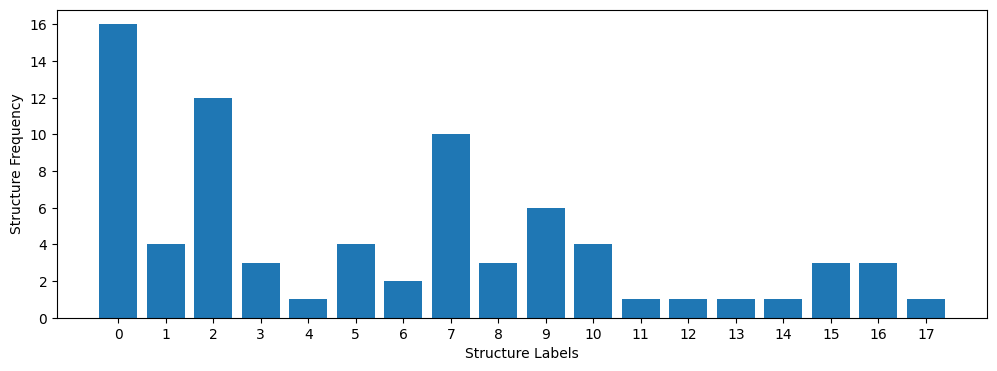

In [19]:
structures = []
for structure_batch in bottomup_objective.structures:
    structures.extend(structure_batch)
plot_structure_histograms(structures)

**Exercise:** Visualize seeds of interest by putting their labels in the `seed_labels` list below.

In [20]:
seed_labels = [0, 2, 8, 10]  # Put seeds of interest here!
for label in seed_labels:
    print(f'structure: {label}')
    draw_structure(label_to_structure(structures, label))

structure: 0
     ┌───────────┐                       ┌───────────┐
q_0: ┤ U3(0,0,0) ├────────────────────■──┤ U3(0,0,0) ├
     ├───────────┤     ┌───────────┐┌─┴─┐├───────────┤
q_1: ┤ U3(0,0,0) ├──■──┤ U3(0,0,0) ├┤ X ├┤ U3(0,0,0) ├
     ├───────────┤┌─┴─┐├───────────┤└───┘└───────────┘
q_2: ┤ U3(0,0,0) ├┤ X ├┤ U3(0,0,0) ├──────────────────
     └───────────┘└───┘└───────────┘                  
structure: 2
     ┌───────────┐                       ┌───────────┐     ┌───────────┐     »
q_0: ┤ U3(0,0,0) ├────────────────────■──┤ U3(0,0,0) ├──■──┤ U3(0,0,0) ├─────»
     ├───────────┤     ┌───────────┐┌─┴─┐├───────────┤┌─┴─┐├───────────┤     »
q_1: ┤ U3(0,0,0) ├──■──┤ U3(0,0,0) ├┤ X ├┤ U3(0,0,0) ├┤ X ├┤ U3(0,0,0) ├──■──»
     ├───────────┤┌─┴─┐├───────────┤└───┘└───────────┘└───┘└───────────┘┌─┴─┐»
q_2: ┤ U3(0,0,0) ├┤ X ├┤ U3(0,0,0) ├────────────────────────────────────┤ X ├»
     └───────────┘└───┘└───────────┘                                    └───┘»
«                  
«q_0: ──────────

Let's put this together now that we have done our analysis. Ideally, we have selected our seeds to start synthesis with, but this might require some experimenting.

**Exercise:** After profiling, select one or more seeds by entering the associated integer label into the `seed_labels` list below.
Note that some less common seeds may still be worth investigating if they are similar to more frequent ones.

In [21]:
seed_labels = [0, 2, 8, 10]

assert len(seed_labels) > 0, "Make sure to put some seeds in the list above!"

# Build the seed structures
seeds = [structure_to_circuit(label_to_structure(structures, s)) for s in seed_labels]

# Build the workflow
layer_gen = SeedLayerGenerator(seeds)
instantiate_options = get_instantiate_options(optimization_level=3)
workflow = [
    QuickPartitioner(3), 
    ForEachBlockPass(
        QSearchSynthesisPass(
            layer_generator=layer_gen,
            instantiate_options=instantiate_options,
        ),
        ScanningGateRemovalPass(instantiate_options=instantiate_options)
    ),
    UnfoldPass()
]

# To record how well we are doing
compiled_circuit_cnot_counts = []

# Start a compiler
compiler = Compiler()

class SeededObjective(EnergyObjective):
    def optimize_evolution(self, bqskit_circuit):
        compiled_circuit = compiler.compile(bqskit_circuit, workflow)
        compiled_circuit_cnot_counts.append(compiled_circuit.count(CNOTGate()))
        return compiled_circuit

bk_objective = SeededObjective(hm_bk, **hm_filling)
start = timer()
min_energy = scipy.optimize.minimize(bk_objective, [0.1]*bk_objective.npar(), method='BFGS')
print("converged in %.0f seconds" % (timer() - start))
print("minimum energy: %.5f (exact: %.5f)" % (min_energy.fun, hubbard.exact(hm_bk, **hm_filling)))
print("Average CNOT gate count: %.2f" % np.mean(compiled_circuit_cnot_counts))

# Close the compiler
compiler.close()

converged in 78 seconds
minimum energy: -1.00000 (exact: -1.00000)
Average CNOT gate count: 85.14


How much speed up did you observe by using seeds? How much was the final CNOT count impacted compared to the baseline workflow? How many seeds do you use to get these results?

More information about a machine learning approach to seed recommendation can be found in the [QSeed paper](https://arxiv.org/abs/2306.05622) [7]. Circuit seeding in bqskit is done with the use of the [SeedLayerGenerator](https://bqskit.readthedocs.io/en/latest/source/autogen/bqskit.passes.SeedLayerGenerator.html).

Implications of Noise
-------------------------

The use of BQSKit truly comes into its own when there is noise present in the system, as is the case in any current, real, QPU: the circuit optimization will show real improvements in the final result. As a note of caution, however: when noise is present, several things change. For example, a noise-resilient optimizer is needed and even then, the final energy result obtained is likely to be higher than the global minimum, even when the final parameters are spot-on. Additionally, simulation with noise takes considerably longer than without, and multiple runs are needed for convincing statistics.

Install scikit-quant, to make its optimizers available as a Qiskit optimizer:

    `$ python -m pip install scikit-quant`

Construct a simple noise model (the circuits as-is will, even after optimization, be too long to be run on current hardware; you can try that by setting `noise_model='realistic'`) and pass it through the constructor of the `EnergyObjective`. Run with the base `EnergyObjective` and with your derived implementation using BQSKit. Compare the results with and without `bqskit` optimization.

In [22]:
from qiskit.algorithms.optimizers import IMFIL
from hubbard import noise_model

logging.getLogger('hubbard').setLevel(logging.INFO)

/tmp/ipykernel_2096299/3757896984.py:1: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import IMFIL


In [23]:
noise = noise_model.create(p_gate_1q=0.01, p_gate_2q=0.02)

In [24]:
objective = EnergyObjective(hm_bk, noise_model=noise, **hm_filling)
npar = objective.npar()

result = IMFIL(maxiter=100).minimize(objective, np.array([0.1]*npar), bounds=np.array([(-1,1)]*npar))
print("minimum energy: %.5f (at solution %s: %.5f; exact: %.5f)" % (
    result.fun, result.x, EnergyObjective(hm_bk, **hm_filling)(result.x), hubbard.exact(hm_bk, **hm_filling)))

hubbard                |     INFO - objective: 0.97980 @ [0.1 0.1]
hubbard                |     INFO - objective: 0.86255 @ [-0.9  0.1]
hubbard                |     INFO - objective: 0.97405 @ [ 0.1 -0.9]
hubbard                |     INFO - objective: 0.90974 @ [-0.29886665  0.08046573]
hubbard                |     INFO - objective: 1.05076 @ [0.70113335 0.08046573]
hubbard                |     INFO - objective: 0.90972 @ [-0.29886665 -0.91953427]
hubbard                |     INFO - objective: 0.86401 @ [-0.778621   0.0804244]
hubbard                |     INFO - objective: 1.00109 @ [0.221379  0.0804244]
hubbard                |     INFO - objective: 0.86508 @ [-0.778621  -0.9195756]
hubbard                |     INFO - objective: 0.89522 @ [-0.4  0.1]
hubbard                |     INFO - objective: 0.86311 @ [-0.9  0.6]
hubbard                |     INFO - objective: 0.86238 @ [-0.9 -0.4]
hubbard                |     INFO - objective: 0.86449 @ [-1.          0.09751847]
hubbard          

In [25]:
objective = MyObjective(hm_bk, noise_model=noise, **hm_filling)
npar = objective.npar()

result = IMFIL(maxiter=100).minimize(objective, np.array([0.1]*npar), bounds=np.array([(-1,1)]*npar))
print("minimum energy: %.5f (at solution %s: %.5f; exact: %.5f)" % (
    result.fun, result.x, EnergyObjective(hm_bk, **hm_filling)(result.x), hubbard.exact(hm_bk, **hm_filling)))

18:32:34.818 - INFO     | bqskit.passes.measure: Extracting measurements from circuit.
18:32:34.821 - INFO     | bqskit.passes.util.log: Retargeting multi-qudit gates.
18:32:34.821 - INFO     | bqskit.passes.util.log: Retargeting multi-qudit gates.
18:32:36.995 - INFO     | bqskit.passes.util.log: Mapping circuit.
18:32:36.995 - INFO     | bqskit.passes.mapping.placement.greedy: Placed qudits on [0, 1, 2, 3]
18:32:37.010 - INFO     | bqskit.passes.mapping.layout.sabre: Found layout: [0, 1, 2, 3]
18:32:37.040 - INFO     | bqskit.passes.mapping.routing.sabre: Finished routing with layout: [0, 1, 2, 3]
18:32:37.040 - INFO     | bqskit.passes.util.log: Retargeting multi-qudit gates.
18:32:38.245 - INFO     | bqskit.passes.util.log: Attempting to delete gates.
18:32:40.374 - INFO     | bqskit.passes.util.log: Upper bound on error is 0.0.
18:32:40.389 - INFO     | bqskit.passes.measure: Restoring measurements to circuit.
hubbard                |     INFO - objective: 0.96460 @ [0.1 0.1]
18:3

## References
-------------

[1] J. Hubbard, Proc. Roy. Soc. (Lond.) 276 (1963) 238
<br>[2] https://github.com/scikit-quant/scikit-quant/tree/master/tutorials
<br>[3] https://arxiv.org/abs/cond-mat/0012334, Ortiz et al., "Quantum Algorithms for Fermionic Simulations"
<br>[4] P. Jordan and E. Wigner, "Über das Paulische Äquivalenzverbot", Z. Phys. 47, 631 (1928)
<br>[5] https://arxiv.org/abs/quant-ph/0003137 S. Bravyi, A. Kitaev, "Fermionic quantum computation"
<br>[6] https://arxiv.org/abs/1812.02233, A. Tranter, et al., "A comparison of the Bravyi-Kitaev and Jordan-Wigner transformations for the quantum simulation of quantum chemistry"
<br>[7] https://arxiv.org/abs/2306.05622, M. Weiden, et al., "Improving Quantum Circuit Synthesis with Machine Learning"